In [1]:
!pip install rembg

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 3.1 MB/s eta 0:00:00


In [2]:
!pip install onnxruntime-gpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.8/280.8 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 7.6 MB/s eta 0:00:00


---
## Import Libraries

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math
import time
from rembg import remove
from PIL import Image
import io
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model

In [12]:
# Image Credits: Tensorflow Doc
content_path = '/content/a.png'
style_path = '/content/second.jpg'
# output_path = '/content/a_no_bg.png'

In [13]:
def load_and_process_image(image_path, max_dim=512):
    img = load_img(image_path, target_size=(max_dim, max_dim))
    img = img_to_array(img)
    img = preprocess_input(img)
    img = np.expand_dims(img, axis=0)

    return img

#### remove background

In [14]:
# from rembg import remove

# # Gunakan nama file dari upload
# input_path = 'a.png'  # ganti sesuai nama file upload
# output_path = 'a_nobg.png'

# # Baca gambar sebagai binary
# with open(input_path, 'rb') as i:
#     input_data = i.read()

# # Hilangkan background
# output_data = remove(input_data)

# # Simpan hasilnya
# with open(output_path, 'wb') as o:
#     o.write(output_data)

# print("✅ Background berhasil dihapus! Disimpan sebagai:", output_path)


---
## Preprocess

In [15]:
def deprocess(img):
    img[:, :, 0] += 103.939
    img[:, :, 1] += 116.779
    img[:, :, 2] += 123.68

    img = img[:, :, ::-1]

    img = np.clip(img, 0, 255).astype(np.uint8)
    return img

def display_image(image):
    if len(image.shape) == 4:
        img = np.squeeze(image, axis=0)

    img = deprocess(img)

    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)
    return

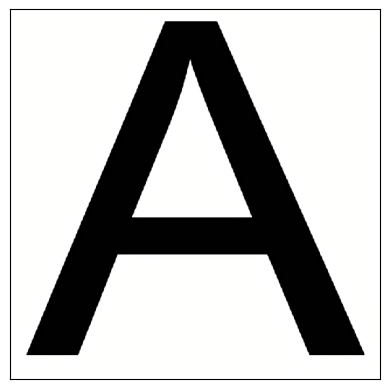

In [16]:
content_img = load_and_process_image(content_path)
display_image(content_img)

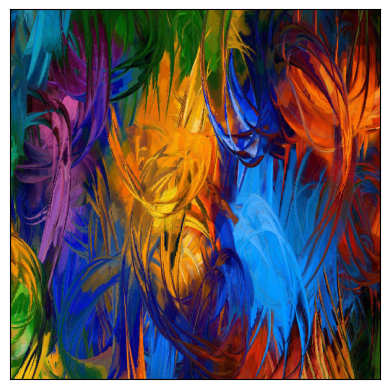

In [17]:
style_img = load_and_process_image(style_path)
display_image(style_img)

---
## Model Initialization

In [18]:
model = VGG19(
    include_top = False,
    weights = 'imagenet'
)

model.trainable = False
model.summary()

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "vgg19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, None, None, 64)      │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, None, None, 64)      │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, None, None, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, None, None, 128)     │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, None, None, 128)     │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, None, None, 128)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, None, None, 256)     │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, None, None, 256)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, None, None, 512)     │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, None, None, 512)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,024,384 (76.39 MB)

In [19]:
content_layer = 'block4_conv2'
content_model = Model(inputs = model.input,
                      outputs = model.get_layer(content_layer).output)

content_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, None, None, 64)      │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, None, None, 64)      │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, None, None, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, None, None, 128)     │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, None, None, 128)     │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, None, None, 128)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, None, None, 256)     │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, None, None, 256)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, None, None, 512)     │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,865,536 (22.38 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 5,865,536 (22.38 MB)

In [20]:
style_layers = [
    'block1_conv1',
    'block2_conv1',
    'block3_conv1',
    'block4_conv1',
    'block5_conv1'
]

style_model = tf.keras.Model(
    inputs=model.input,
    outputs=[model.get_layer(layer).output for layer in style_layers]
)


#### content loss

In [21]:
def content_loss(content, generated, weight=1.0):
    a_C = content_model(content)
    a_G = content_model(generated)

    N_l = tf.shape(a_C)[-1]
    M_l = tf.shape(a_C)[1] * tf.shape(a_C)[2]

    loss = tf.reduce_sum(tf.square(a_G - a_C))

    loss = (weight / (2.0 * tf.cast(N_l * M_l, tf.float32))) * loss
    return loss

#### gram matrix / style loss

In [22]:
def gram_matrix(A):
    channels = int(A.shape[-1])
    a = tf.reshape(A, [-1, channels])
    n = tf.shape(a)[0]
    gram = tf.matmul(a,a,transpose_a = True)
    return gram/tf.cast(n, tf.float32)

weight_of_layer =  1./len(style_layers)

#### style loss

In [23]:
def style_cost(style, generated, weight=None):
    style_outputs = style_model(style)
    generated_outputs = style_model(generated)

    if not isinstance(style_outputs, list):
        style_outputs = [style_outputs]
        generated_outputs = [generated_outputs]

    if weight is None:
        weight = [1.0] * len(style_outputs)

    if isinstance(weight, (int,float)):
        weight = [weight] * len(style_outputs)
    total_loss = 0.0

    for s_out, g_out, w in zip(style_outputs, generated_outputs, weight):
        N_l = tf.shape(s_out)[-1]
        M_l = tf.shape(s_out)[1] * tf.shape(s_out)[2]

        G_style = gram_matrix(s_out)
        G_generated = gram_matrix(g_out)

        loss = tf.reduce_sum(tf.square(G_generated - G_style))
        denom = 4.0 * tf.cast(N_l, tf.float32)**2 * tf.cast(M_l, tf.float32)**2
        loss = w * loss / denom
        total_loss += loss

    return total_loss

#### patch loss

In [24]:
def patch_loss(patch_real, patch_generated, weight=1.0):
  loss = tf.reduce_mean(tf.square(patch_real - patch_generated))
  return loss

#### distance loss

In [25]:
def distance_loss(edge_real, edge_generated, weight=1.0):
  loss = tf.reduce_mean(tf.square(edge_real - edge_generated))
  return loss

#### total loss

In [26]:
def total_loss(content, generated, style,
               patch_real, patch_generated,
               edge_real, edge_generated,
               alpha=1.0, beta=1.0, gamma=1.0, delta=1.0):
    L_content = content_loss(content, generated, weight=alpha)
    L_style = style_cost(style, generated, weight=beta)
    L_patch = patch_loss(patch_real, patch_generated, weight=gamma)
    L_distance = distance_loss(edge_real, edge_generated, weight=delta)
    return alpha * L_content + beta * L_style + gamma * L_patch + delta * L_distance

---
## Training Functions

In [31]:
# Folder penyimpanan hasil
CHECKPOINT_DIR = "checkpoints"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

def save_image(tensor, filename):
    """Ubah tensor jadi image dan simpan."""
    image = tensor.numpy().squeeze()
    image = np.clip(image, 0, 255).astype('uint8')
    Image.fromarray(image).save(filename)

generated_images = []

def training_loop(content_path, style_path, iterations=5000, alpha=10, beta=1000, gamma=200, delta=5, checkpoint_interval=100):
    content = load_and_process_image(content_path)
    style = load_and_process_image(style_path)
    generated = tf.Variable(content, dtype=tf.float32)

    patch_real = content
    patch_generated = generated

    edge_real = tf.image.sobel_edges(tf.convert_to_tensor(content))
    edge_generated = tf.image.sobel_edges(tf.convert_to_tensor(generated))

    opt = tf.keras.optimizers.Adam(learning_rate=0.7)
    best_cost = math.inf
    best_image = None

    for i in range(iterations):
        start_time_cpu = time.process_time()
        start_time_wall = time.time()

        with tf.GradientTape() as tape:
            J_total = total_loss(content, generated, style,
                                 patch_real, patch_generated,
                                 edge_real, edge_generated,
                                 alpha=alpha, beta=beta, gamma=gamma, delta=delta)

        grads = tape.gradient(J_total, generated)
        opt.apply_gradients([(grads, generated)])

        end_time_cpu = time.process_time()
        end_time_wall = time.time()

        cpu_time = end_time_cpu - start_time_cpu
        wall_time = end_time_wall - start_time_wall

        # Simpan hasil terbaik
        if J_total < best_cost:
            best_cost = J_total
            best_image = generated.numpy()
            save_image(generated, f"{CHECKPOINT_DIR}/best_image.png")

        # Simpan checkpoint setiap beberapa iterasi
        if i % checkpoint_interval == 0:
            checkpoint_path = f"{CHECKPOINT_DIR}/step_{i}.png"
            save_image(generated, checkpoint_path)
            print(f"Checkpoint saved at step {i} -> {checkpoint_path}")

        print("CPU times: user {} µs, sys: {} ns, total: {} µs".format(
            int(cpu_time * 1e6),
            int((end_time_cpu - start_time_cpu) * 1e9),
            int((end_time_cpu - start_time_cpu + 1e-6) * 1e6))
        )

        print("Wall time: {:.2f} µs".format(wall_time * 1e6))
        print("Iteration: {}".format(i))
        print('Total Loss {:e}.'.format(J_total))

        generated_images.append(generated.numpy())

    # Simpan final image
    save_image(generated, f"{CHECKPOINT_DIR}/final_image.png")
    print("Final image saved!")

    return best_image


In [ ]:
final_image = training_loop(content_path, style_path)

Checkpoint saved at step 0 -> checkpoints/step_0.png
CPU times: user 69452054 µs, sys: 69452054705 ns, total: 69452055 µs
Wall time: 41899853.23 µs
Iteration: 0
Total Loss 7.843554e+09.
CPU times: user 68736177 µs, sys: 68736177360 ns, total: 68736178 µs
Wall time: 42218659.40 µs
Iteration: 1
Total Loss 7.326863e+09.
CPU times: user 67917282 µs, sys: 67917282973 ns, total: 67917283 µs
Wall time: 42216383.93 µs
Iteration: 2
Total Loss 6.799420e+09.
CPU times: user 68072581 µs, sys: 68072581699 ns, total: 68072582 µs
Wall time: 41079756.74 µs
Iteration: 3
Total Loss 6.372274e+09.
CPU times: user 66993198 µs, sys: 66993198558 ns, total: 66993199 µs
Wall time: 41109966.28 µs
Iteration: 4
Total Loss 5.975920e+09.
CPU times: user 66959166 µs, sys: 66959166812 ns, total: 66959167 µs
Wall time: 40342770.10 µs
Iteration: 5
Total Loss 5.597712e+09.
CPU times: user 66922583 µs, sys: 66922583445 ns, total: 66922584 µs
Wall time: 40537536.62 µs
Iteration: 6
Total Loss 5.237855e+09.
CPU times: user 

In [ ]:
plt.figure(figsize=(10,10))

for i in range(10):
  plt.subplot(4,3,i+1)
  display_image(generated_images[i+39])
  plt.show()

display_image(final_image)